In [2]:
# Load libraries

import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pySuStaIn
import statsmodels.formula.api as smf
from scipy import stats
import sklearn.model_selection
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import os
import shutil
import math
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import minimize
from Module_1_functions import age_regression, z_scoring

## Settings

In [3]:
# Define biomarkers to input to staging module (make sure they correspond to column titles in the csv)
selected_biomarkers = ['ADAS11','HIPPOCAMPUS_VOLUME','HIPPOCAMPUS_SUVR','CTX_ENTORHINAL_SUVR']

# Color palette for diagnoses 
diagnosis_palette = {
    'AD': '#145A32',  # Deep evergreen
    'MCI': '#9ACD32',       # Yellow-green
    'CN': '#FFFACD'}        # Light yellow/cream

## Pre-Processing Data

In [4]:
# Load data
data = pandas.read_csv('/Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/sustaln/SuStaIn/raw data/ADNI4/Tau_ADAS_paired_withAgeDX.csv')
data = data.drop(columns=['Unnamed: 0'])

In [5]:
# Process the data. including age-regression and z-scoring

# Identify biomarker data from meta data
meta_data = data.iloc[:, :30] # MAKE SURE YOU ARE USING THE RIGHT INDEX
biomarker_data = data.iloc[:, 30:] 

# First, perform age regression on all data
age_data = meta_data['AGE_AT_SCAN']
biomarker_data_age_regressed = age_regression(biomarker_data, age_data)

# Next, correct tau data by cerebellum
tau_data = biomarker_data_age_regressed.loc[:, biomarker_data_age_regressed.columns.str.contains('SUVR')]
tau_data = tau_data.div(tau_data['CEREBELLUM_CORTEX_SUVR'], axis=0)

# Put the corrected tau data back into biomarker_data_age_regressed
biomarker_data_age_regressed.loc[:, biomarker_data_age_regressed.columns.str.contains('SUVR')] = tau_data

# Then z-score all the data
diagnosis_data = meta_data['DIAGNOSIS']
biomarker_data_z_scored = z_scoring(biomarker_data_age_regressed, diagnosis_data)

# Split into different biomarker types and negate volumes
tau_data = biomarker_data_z_scored.loc[:, biomarker_data_z_scored.columns.str.contains('SUVR')]
regional_volume_data = biomarker_data_z_scored.loc[:, biomarker_data_z_scored.columns.str.contains('VOLUME')] * -1  # Negate volumes after z-scoring
cognitive_score_data = biomarker_data_z_scored.loc[:, biomarker_data_z_scored.columns.str.contains('ADAS')]

# Combine all data
combined_data = pandas.concat([meta_data, tau_data, regional_volume_data, cognitive_score_data], axis=1)

# Take only data for the selected biomarkers
processed_data = combined_data[list(meta_data.columns) + list(selected_biomarkers)]

## Visualize Biomarker Inputs

/var/folders/s8/x9wmskq97fv12b1hfqdfvybh0000gn/T/ipykernel_92403/2109752993.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Diagnosis')


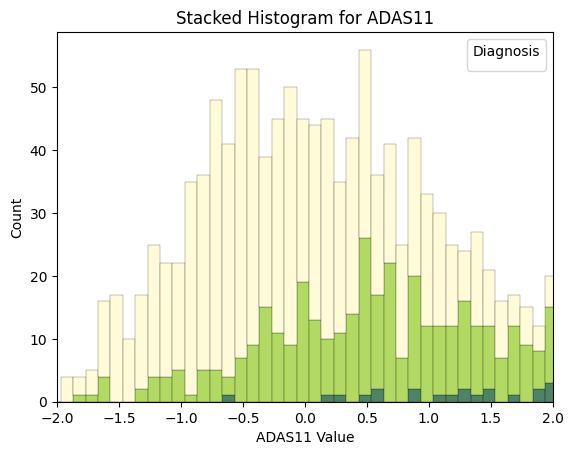

/var/folders/s8/x9wmskq97fv12b1hfqdfvybh0000gn/T/ipykernel_92403/2109752993.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Diagnosis')


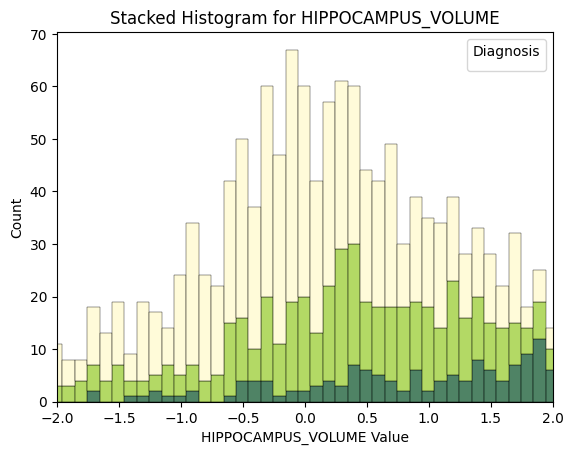

/var/folders/s8/x9wmskq97fv12b1hfqdfvybh0000gn/T/ipykernel_92403/2109752993.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Diagnosis')


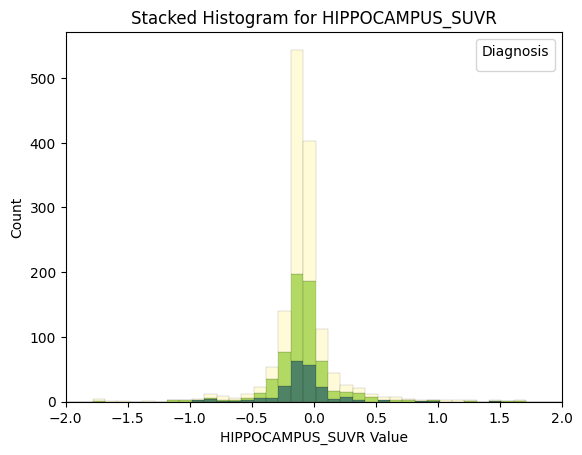

/var/folders/s8/x9wmskq97fv12b1hfqdfvybh0000gn/T/ipykernel_92403/2109752993.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Diagnosis')


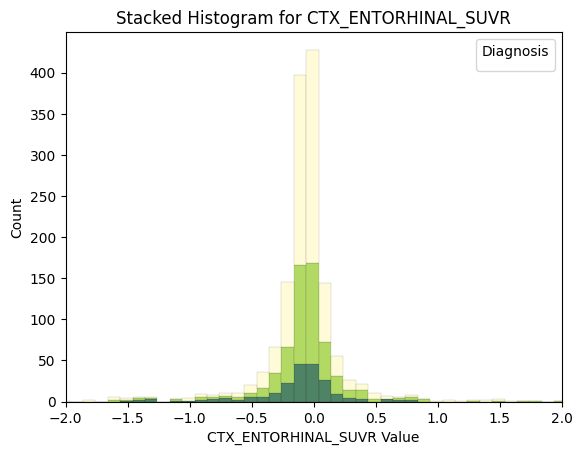

In [19]:
# Plot biomarker histograms check their distributions

for biomarker in selected_biomarkers:
    plt.figure()  # Creates a new figure for each plot
    bin_width = 0.1
    sns.histplot(data=processed_data, x=biomarker, hue='DIAGNOSIS', 
             binwidth=bin_width, multiple='stack', palette=diagnosis_palette)
    plt.title(f'Stacked Histogram for {biomarker}')
    plt.xlabel(f'{biomarker} Value')
    plt.ylabel('Count')
    plt.xlim(-2, 2)
    plt.legend(title='Diagnosis')
    plt.show()

# Prepare Event-based Model Inputs

In [6]:
# Define abnormality thresholds for each biomarker 
N = len(selected_biomarkers) # Number of biomarkers

SuStaInLabels = selected_biomarkers

Z_vals = np.array([[1,2,3] for _ in range(N)])     # Z-scores for each biomarker 
Z_max = np.array([5] * N)  # maximum z-score - set to 5 for each biomarker

In [7]:
# Prepare data for input to SuStaIn

# # First, let's see how many missing values we have in each biomarker
print("Number of missing values per biomarker:")
print(data[list(selected_biomarkers)].isnull().sum())

# Remove rows with any missing values in our biomarkers of interest
zdata = data.dropna(subset=list(selected_biomarkers))

print("\nShape after removing missing values:", zdata.shape)

# 1. First clean the data
zdata_clean = zdata.dropna(subset=list(selected_biomarkers))

# 2. Check the range of values
print("Data ranges:")
print(zdata_clean[list(selected_biomarkers)].describe())

# 3. Normalize the data to a reasonable range (e.g., z-scores)

# Create normalized version of the data
normalized_data = zdata_clean.copy()
for col in selected_biomarkers:
    normalized_data[col] = stats.zscore(zdata_clean[col])

# Add a small epsilon to prevent zeros
epsilon = 1e-10
normalized_data[list(selected_biomarkers)] = normalized_data[list(selected_biomarkers)].clip(lower=epsilon)

Number of missing values per biomarker:
ADAS11                 22
HIPPOCAMPUS_VOLUME     96
HIPPOCAMPUS_SUVR       96
CTX_ENTORHINAL_SUVR     9
dtype: int64

Shape after removing missing values: (1486, 358)
Data ranges:
            ADAS11  HIPPOCAMPUS_VOLUME  HIPPOCAMPUS_SUVR  CTX_ENTORHINAL_SUVR
count  1486.000000         1486.000000       1486.000000          1486.000000
mean      8.775417         7625.559892          1.281495             1.278277
std       6.779165         1052.672455          0.185634             0.268672
min       0.000000         3255.000000          0.827000             0.827000
25%       4.330000         7004.000000          1.154000             1.089000
50%       6.670000         7679.500000          1.255000             1.188000
75%      11.330000         8310.000000          1.380000             1.400750
max      56.000000        11461.000000          2.334000             2.834000


In [8]:
# Input the settings for SuStaIn (the subtyping and staging algorithm)
N_startpoints = 25 # Recomended: 25
N_S_max = 1 # Number of subtypes
N_iterations_MCMC = int(1e4) # To start use int(1e4), increase this to 1e5 or 1e6
output_folder = os.path.join(os.getcwd(), 'WorkshopOutput')
dataset_name = 'WorkshopOutput'

# Initiate the SuStaIn object
sustain_input = pySuStaIn.ZscoreSustain(
                              normalized_data[selected_biomarkers].values,
                              Z_vals,
                              Z_max,
                              SuStaInLabels,
                              N_startpoints,
                              N_S_max, 
                              N_iterations_MCMC, 
                              output_folder, 
                              dataset_name, 
                              False)

# Run the event-based model!

In [9]:
# Delete pickle file 
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)

In [10]:
# make the output directory if it's not already created
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

In [11]:
samples_sequence,   \
samples_f,          \
ml_subtype,         \
prob_ml_subtype,    \
ml_stage,           \
prob_ml_stage,      \
prob_subtype_stage  = sustain_input.run_sustain_algorithm()

Failed to find pickle file: /Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/sustaln/SuStaIn/notebooks/WorkshopOutput/pickle_files/WorkshopOutput_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -8749.748955234518


MCMC Iteration: 100%|██████████| 10000/10000 [00:04<00:00, 2324.23it/s]


In [339]:
# Get model output from pickle file
s = N_S_max - 1 # Which subtype
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pandas.read_pickle(pickle_filename_s)

# Stage individuals

In [341]:
# The SuStaIn output has everything we need. We'll use it to populate our dataframe.

pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pandas.read_pickle(pickle_filename_s)

for variable in ['ml_subtype', # the assigned subtype
                 'prob_ml_subtype', # the probability of the assigned subtype
                 'ml_stage', # the assigned stage 
                 'prob_ml_stage',]: # the probability of the assigned stage
    
    # add SuStaIn output to dataframe
    data.loc[:,variable] = pk[variable] 

for i in range(s):
    zdata.loc[:,'prob_S%s'%i] = pk['prob_subtype'][:,i]

data

,LONIUID,RID,VISCODE_x,SCANDATE,PROCESSDATE,IMAGE_RESOLUTION,qc_flag,TRACER,TRACER_SUVR_WARNING,update_stamp,...,PTRACCAT,AGE_AT_SCAN,ADAS11,HIPPOCAMPUS_VOLUME,HIPPOCAMPUS_SUVR,CTX_ENTORHINAL_SUVR,ml_subtype,prob_ml_subtype,ml_stage,prob_ml_stage
0,I1594604,21,init,2018-02-02,2022-09-02,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,4,85.002053,-0.158089,-0.333452,1.125602,-0.610222,0.0,1.0,1.0,0.243336
1,I1596177,31,init,2018-04-24,2022-09-02,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,5,90.310746,-1.594868,0.677056,-0.103363,-0.093651,0.0,1.0,0.0,0.269842
2,I1596172,31,y1,2019-04-23,2022-09-02,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,5,91.307324,-1.639684,0.896525,-0.053984,-0.108294,0.0,1.0,0.0,0.252782
3,I1598898,56,init,2018-02-20,2022-09-02,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,4,81.973990,-1.579745,0.257640,-0.012954,-0.043957,0.0,1.0,0.0,0.292796
4,I1598985,56,y1,2019-01-10,2022-09-02,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,4,82.861054,0.179240,0.041200,-3.136145,0.070251,0.0,1.0,0.0,0.286439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1512,I1648618,7114,bl,2022-12-06,2023-05-26,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,4,65.842574,-1.332827,0.476783,-0.081477,-0.049276,0.0,1.0,0.0,0.285611
1513,I10279040,7117,bl,2023-02-07,2023-12-08,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,4,69.267625,0.070977,0.326873,0.453779,-0.285563,0.0,1.0,0.0,0.264148
1514,I10239398,7121,bl,2023-05-10,2023-09-28,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,5,62.436687,0.259434,1.458200,-0.283794,-0.438036,0.0,1.0,1.0,0.214025
1515,I10298377,7123,bl,2023-05-18,2024-01-03,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,6,80.459959,0.405942,1.429477,-0.214746,-0.148110,0.0,1.0,1.0,0.215126


In [319]:
# Save zdata to a new file for analysis (GO TO PROCESSING MODEL OUTPUT)
zdata.to_csv('/Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/sustaln/SuStaIn/zdata/StaND + DNN/zdata: ADNI4 iteration 3.csv')

In [342]:
zdata.ml_subtype.value_counts()
zdata.ml_stage.value_counts()

ml_stage
0.0     1003
1.0      160
2.0      125
3.0       51
6.0       42
7.0       35
8.0       24
5.0       22
4.0        9
12.0       5
9.0        5
11.0       4
10.0       1
Name: count, dtype: int64

As a sanity check, let's make sure all the "controls" were given assigned to low stages by SuStaIn

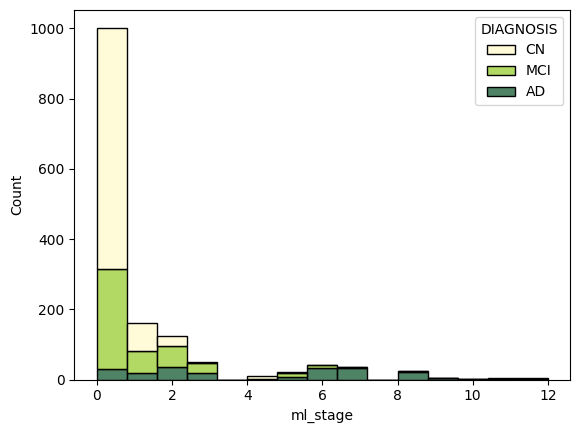

In [343]:
# Use clincial diagnostic categories as a rough way to assess the sucess of the model's stage assignments

sns.histplot(data=zdata, x='ml_stage', hue='DIAGNOSIS', bins=15, multiple='stack', palette=diagnosis_palette)
plt.show()

In [ ]:
# Access pickle file
output_folder = os.path.join(os.getcwd(), 'WorkshopOutput')
dataset_name = 'WorkshopOutput'

# Get model output from pickle file
s = 0
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pandas.read_pickle(pickle_filename_s)

# let's take a look at all of the things that exist in SuStaIn's output (pickle) file
pk.keys()

dict_keys(['samples_sequence', 'samples_f', 'samples_likelihood', 'ml_subtype', 'prob_ml_subtype', 'ml_stage', 'prob_ml_stage', 'prob_subtype', 'prob_stage', 'prob_subtype_stage', 'ml_sequence_EM', 'ml_sequence_prev_EM', 'ml_f_EM', 'ml_f_prev_EM'])

In [ ]:
# Load specific zdata you want to analyze (make sure the number of subtypes and input features are correct)
zdata = pandas.read_csv('/Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/sustaln/SuStaIn/zdata/StaND + DNN/zdata: ADNI4 iteration 3.csv')
zdata

,Unnamed: 0,LONIUID,RID,VISCODE_x,SCANDATE,PROCESSDATE,IMAGE_RESOLUTION,qc_flag,TRACER,TRACER_SUVR_WARNING,...,PTRACCAT,AGE_AT_SCAN,ADAS11,HIPPOCAMPUS_VOLUME,HIPPOCAMPUS_SUVR,CTX_ENTORHINAL_SUVR,ml_subtype,prob_ml_subtype,ml_stage,prob_ml_stage
0,0,I1594604,21,init,2018-02-02,2022-09-02,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,...,4,85.002053,-0.158089,-0.333452,1.125602,-0.610222,0.0,1.0,1.0,0.242790
1,1,I1596177,31,init,2018-04-24,2022-09-02,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,...,5,90.310746,-1.594868,0.677056,-0.103363,-0.093651,0.0,1.0,0.0,0.269032
2,2,I1596172,31,y1,2019-04-23,2022-09-02,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,...,5,91.307324,-1.639684,0.896525,-0.053984,-0.108294,0.0,1.0,0.0,0.252701
3,3,I1598898,56,init,2018-02-20,2022-09-02,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,...,4,81.973990,-1.579745,0.257640,-0.012954,-0.043957,0.0,1.0,0.0,0.290937
4,4,I1598985,56,y1,2019-01-10,2022-09-02,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,...,4,82.861054,0.179240,0.041200,-3.136145,0.070251,0.0,1.0,0.0,0.284447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1481,1512,I1648618,7114,bl,2022-12-06,2023-05-26,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,...,4,65.842574,-1.332827,0.476783,-0.081477,-0.049276,0.0,1.0,0.0,0.284102
1482,1513,I10279040,7117,bl,2023-02-07,2023-12-08,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,...,4,69.267625,0.070977,0.326873,0.453779,-0.285563,0.0,1.0,0.0,0.262386
1483,1514,I10239398,7121,bl,2023-05-10,2023-09-28,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,...,5,62.436687,0.259434,1.458200,-0.283794,-0.438036,0.0,1.0,1.0,0.214702
1484,1515,I10298377,7123,bl,2023-05-18,2024-01-03,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,...,6,80.459959,0.405942,1.429477,-0.214746,-0.148110,0.0,1.0,1.0,0.215767


In [ ]:
# SPECIFY THE NUMBER OF SUBTYPES
nsubtypes = 1

## Generate Stage Histogram

In [11]:
# Count number of subjects in each stage
stage_counts = zdata['ml_stage'].value_counts().sort_index()

print("Number of subjects in each stage:")
for stage, count in stage_counts.items():
    print(f"Stage {int(stage)}: {count} subjects")

NameError: name 'zdata' is not defined

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

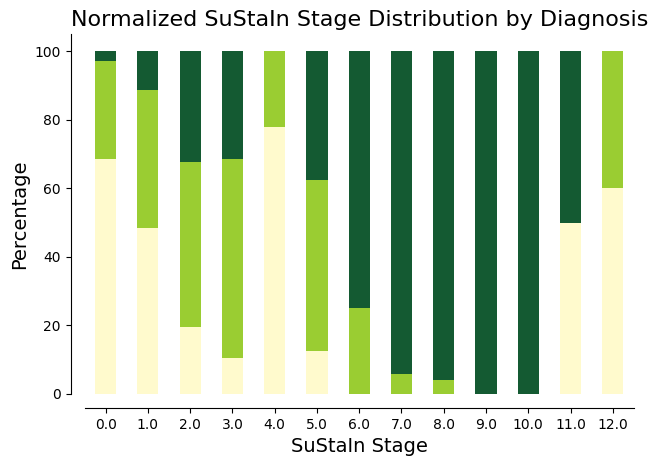

In [ ]:
# Use clincial diagnostic categories as a rough way to assess the success of the model's stage assignments

for subtype in range(nsubtypes):
    
    plt.figure(figsize=(12, 8))
    # Create a normalized stacked bar chart
    plt.figure(figsize=(12, 8))

    # Filter data for the current subtype
    subtype_data = zdata[zdata['ml_subtype'] == subtype]

    # Group the data by ml_stage and Diagnosis, then count the occurrences
    stage_diagnosis_counts = zdata.groupby(['ml_stage', 'DIAGNOSIS']).size().unstack(fill_value=0)

    # Sort the index (ml_stage) to ensure proper ordering
    stage_diagnosis_counts = stage_diagnosis_counts.sort_index()

    # Calculate the percentage for each diagnosis within each stage
    stage_diagnosis_percentages = stage_diagnosis_counts.apply(lambda x: x / x.sum() * 100, axis=1)

    # Reorder the columns to have AD at the bottom, then MCI, then CN
    stage_diagnosis_percentages = stage_diagnosis_percentages[['CN', 'MCI', "AD"]]

    # Create the normalized stacked bar chart with the new order
    ax = stage_diagnosis_percentages.plot(kind='bar', stacked=True, color=[diagnosis_palette[d] for d in stage_diagnosis_percentages.columns])

    # Customize the plot
    plt.title('Normalized SuStaIn Stage Distribution by Diagnosis', fontsize=16)
    plt.xlabel('SuStaIn Stage', fontsize=14)
    plt.ylabel('Percentage', fontsize=14)
    plt.legend(title='Diagnosis', fontsize=12, title_fontsize=14)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    # Remove the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Extend the left and bottom spines to the edges of the plot
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    plt.legend().remove()  
    plt.show()

# Trajectory plots for each biomarker

In [ ]:
# store our biomarker labels as a variable
selected_biomarkers = ['ADAS11','HIPPOCAMPUS_VOLUME','HIPPOCAMPUS_SUVR','CTX_ENTORHINAL_SUVR']
print(selected_biomarkers)

['ADAS11', 'HIPPOCAMPUS_VOLUME', 'HIPPOCAMPUS_SUVR', 'CTX_ENTORHINAL_SUVR']


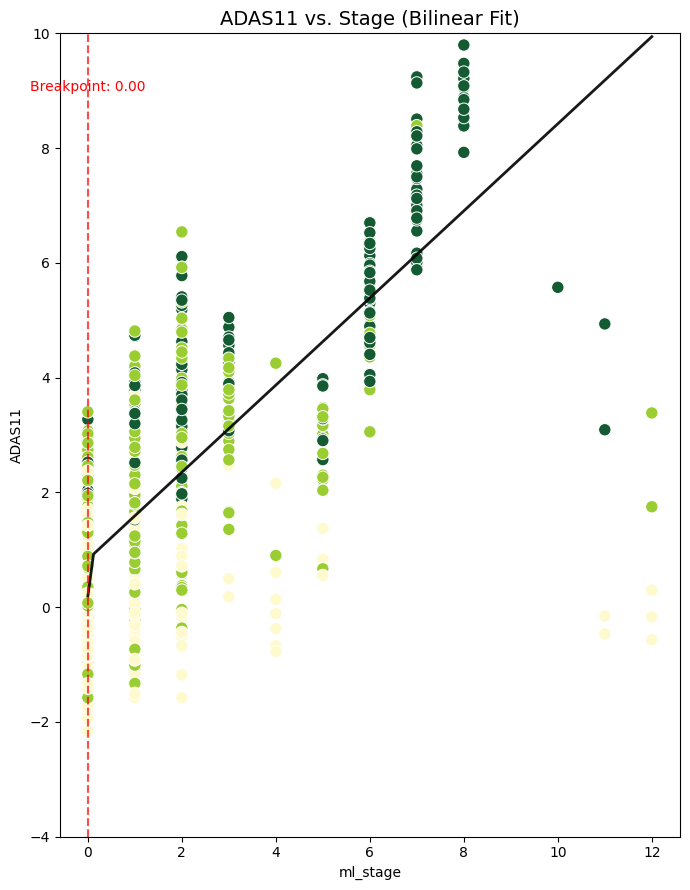

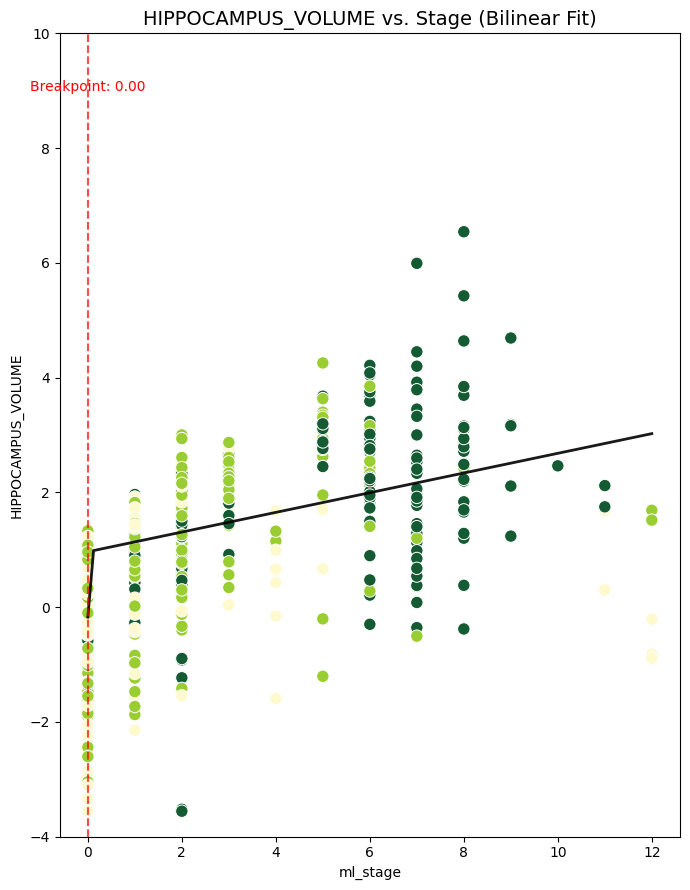

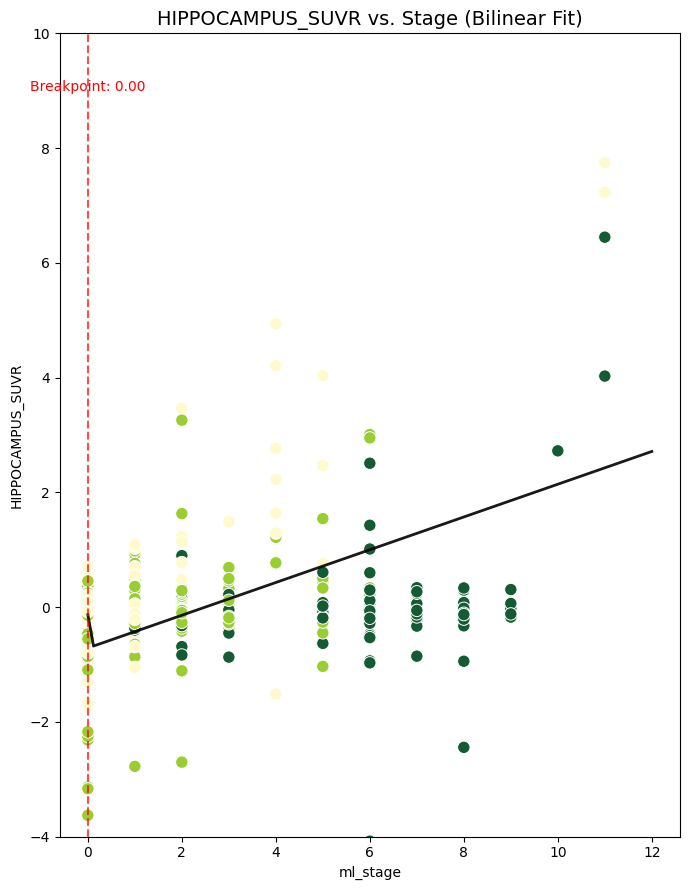

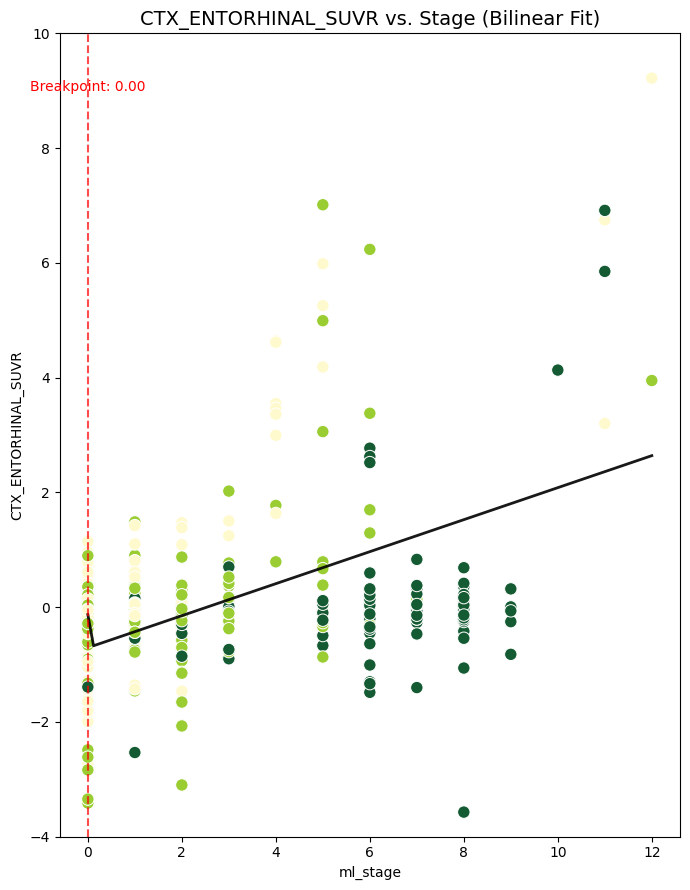

In [ ]:
# Plot biomarker trajectories by diagnosis (bilinear fit)
def bilinear_func(x, params):
    """Bilinear function with breakpoint"""
    a1, b1, a2, b2, breakpoint = params
    return np.where(x <= breakpoint,
                   a1 * x + b1,  # First line
                   a2 * x + b2)  # Second line

def fit_bilinear(x, y):
    """Fit bilinear regression"""
    def objective(params):
        y_pred = bilinear_func(x, params)
        return np.sum((y - y_pred)**2)
    
    # Initial guess: breakpoint at median x
    x_mid = np.median(x)
    initial_guess = [1, 0, 1, 0, x_mid]  # [a1, b1, a2, b2, breakpoint]
    
    # Constrain breakpoint to be within data range
    bounds = [(-np.inf, np.inf), (-np.inf, np.inf),
              (-np.inf, np.inf), (-np.inf, np.inf),
              (x.min(), x.max())]
    
    result = minimize(objective, initial_guess, bounds=bounds)
    return result.x

# Apply to your data
for biomarker in selected_biomarkers:
    fig, ax = plt.subplots(figsize=(7, 9))
    
    # Plot scatter points
    sns.scatterplot(x='ml_stage', y=biomarker, data=zdata,
                   hue='DIAGNOSIS', palette=diagnosis_palette,
                   s=80, legend=False, ax=ax)
    
    # Fit bilinear regression
    x_vals = zdata['ml_stage'].values
    y_vals = zdata[biomarker].values
    
    # Remove NaN values
    mask = ~(np.isnan(x_vals) | np.isnan(y_vals))
    x_clean = x_vals[mask]
    y_clean = y_vals[mask]
    
    if len(x_clean) > 5:  # Need enough points to fit
        params = fit_bilinear(x_clean, y_clean)
        
        # Generate smooth line for plotting
        x_plot = np.linspace(x_clean.min(), x_clean.max(), 100)
        y_plot = bilinear_func(x_plot, params)
        
        # Plot bilinear regression
        ax.plot(x_plot, y_plot, color='black', linewidth=2, alpha=0.9)
        
        # Add breakpoint annotation
        breakpoint = params[4]
        ax.axvline(x=breakpoint, color='red', linestyle='--', alpha=0.7)
        ax.text(breakpoint, 9,  # Fixed y-position instead of dynamic
                f'Breakpoint: {breakpoint:.2f}',
                ha='center', fontsize=10, color='red')
    
    ax.set_ylim(-4, 10)
    ax.set_title(f'{biomarker} vs. Stage (Bilinear Fit)', fontsize=14)  # Use ax.set_title()
    plt.tight_layout()  # This helps with spacing
    plt.show()

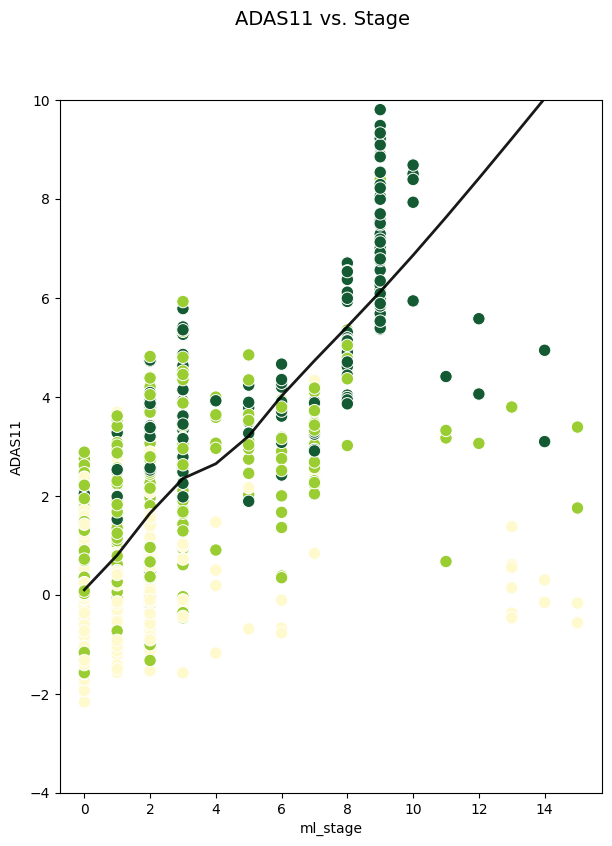

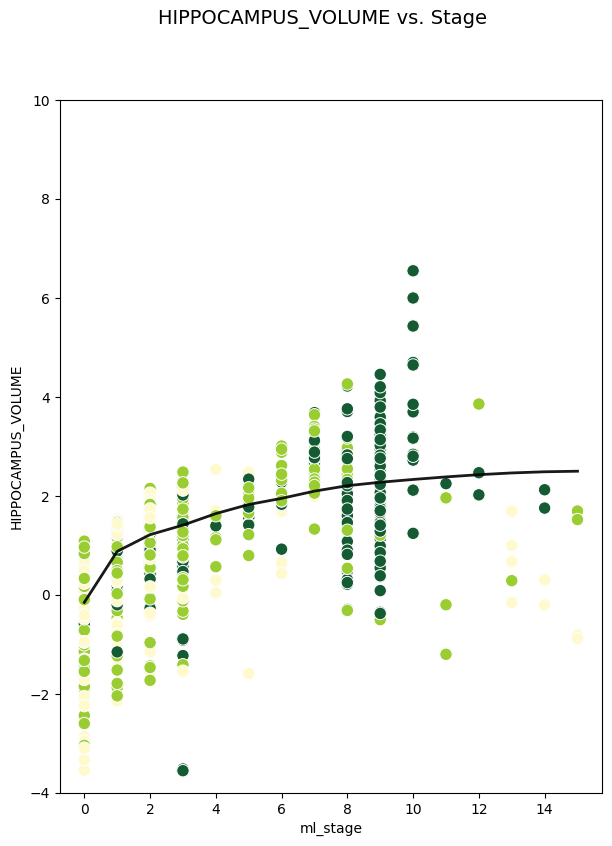

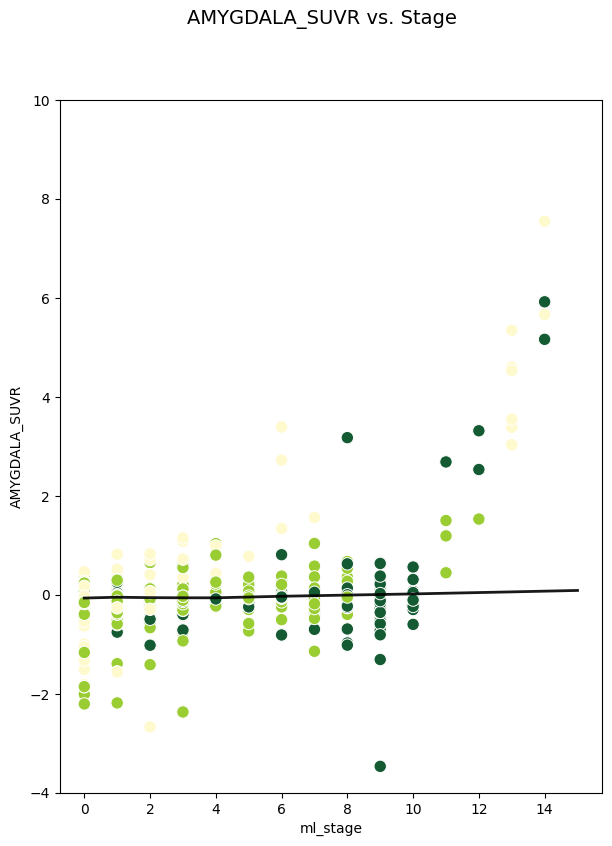

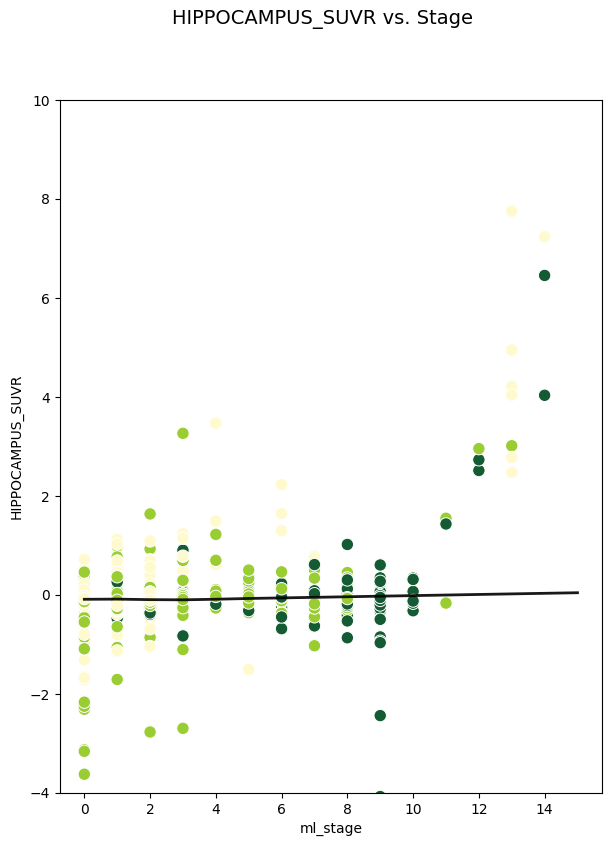

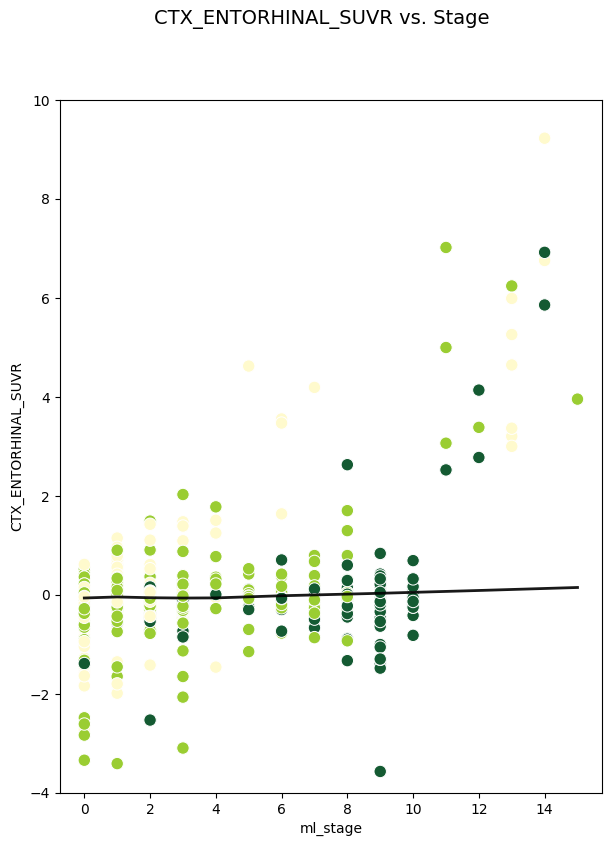

In [ ]:
# Plot biomarker trajectories by diagnosis (LOWESS)

for biomarker in selected_biomarkers:
    fig, ax = plt.subplots(figsize=(7, 9))

    # Plot scatter points
    sns.scatterplot(x='ml_stage', y=biomarker, data=zdata, 
                    hue='DIAGNOSIS', palette=diagnosis_palette,
                    s=80, legend=False)  # Adjust scatter point size if needed

    # Add a regression line for all data
    sns.regplot(x='ml_stage', y=biomarker, data=zdata, 
                scatter=False, 
                color='black',  # Choose a color for the regression line
                lowess=True,
                line_kws={'lw': 2, 'alpha': 0.9})  # Thinner line (lw: line width)

    ax.set_ylim(-4, 10)

    # Add a title to the plot
    plt.gcf().suptitle(str(biomarker) + ' vs. Stage', fontsize=14) 

    plt.show()

# Calculate y_k at each stage for a biomarker
Can use this code for any biomarker, including tau regional values and functional metrics. 

In [ ]:
# Load data for biomarker of interest (in this case tau densities)
tau_data = pandas.read_csv('/Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/sustaln/SuStaIn/raw data/ADNI3/Cog_Tau_V1.csv')

#Housekeeping
tau_data = tau_data.drop(['Unnamed: 0'], axis=1)
tau_data = tau_data.rename(columns ={'merge_RID' : 'RID'})

# Delete RIDs with NaN values in any column (only run for 'Cog_Tau_V1.csv') and redundant RIDS if cross-sectional 
#indices_to_drop = [97,105, 238, 250, 388, 400, 439, 454, 734, 778] 
#tau_data = tau_data.drop(indices_to_drop, axis=0)
value_to_drop = [4513, 6038, 6505, 6598, 6601, 6509]    
tau_data = tau_data[~tau_data['RID'].isin(value_to_drop)]
tau_data = tau_data.drop_duplicates(subset='RID', keep='first')

# Delete subjects with stages to exclude or diagnoses to exclude
# tau_data = tau_data[tau_data['RID'].isin(reduced_RIDs)]

# Find the average of the right and left cerebellum 
tau_data['Average_Cerebellum'] = (tau_data['Left-Cerebellum-Cortex']+ tau_data['Right-Cerebellum-Cortex'])/2

# Divide each regional tau value by the average of R and L cerebellum tau and subtract 1
tau_data.iloc[:, 6:] = tau_data.iloc[:, 6:].div(tau_data['Average_Cerebellum'], axis=0) - 1

tau_data = tau_data.drop(columns=['Average_Cerebellum', 'MMSE_bl', 'ADAS11_bl', 'ADAS13_bl', 'merge_DX', 'best_DX'])

# Reset index for tau
tau_data.reset_index(drop=True, inplace=True)

In [ ]:
# Check the same RIDs exist in tau data and zdata

rid_tau = set(tau_data['RID'])
rid_z = set(zdata['RID'])

# Find RIDs in df1 but not in df2
only_in_tau = rid_tau - rid_z

# Find RIDs in df2 but not in df1
only_in_z = rid_z - rid_tau

# Find RIDs common to both DataFrames
common_rids = rid_tau.intersection(rid_z)

# Print results
print("RIDs only in tau_data:", only_in_tau)
print("RIDs only in zdata:", only_in_z)
print("RIDs common to both DataFrames:", common_rids)


RIDs only in tau_data: {6402, 2180, 6405, 4868, 5127, 1414, 142, 6414, 6163, 5269, 2200, 4889, 5273, 6300, 2333, 4380, 6697, 4399, 4400, 5176, 4281, 6207, 6212, 6213, 4552, 4809, 6221, 4430, 6351, 4815, 4177, 5202, 2133, 4309, 4313, 6364, 4446, 734, 6373, 6376, 751, 6266}
RIDs only in zdata: {6657, 6669, 6673, 5141, 6679, 6170, 6682, 6689, 6691, 4644, 6693, 6695, 6696, 555, 6700, 4143, 6192, 6707, 6708, 6709, 6714, 6717, 6719, 6724, 6726, 6727, 6730, 6731, 6733, 6734, 6735, 6739, 6742, 6744, 4188, 6748, 6750, 6751, 6241, 6754, 6244, 6757, 6760, 6761, 6763, 5228, 6765, 6254, 6768, 6770, 6771, 6773, 5237, 6775, 4216, 6777, 6779, 6780, 6784, 6273, 6785, 6786, 6788, 6789, 6790, 6796, 6285, 6797, 6798, 6800, 6801, 6802, 6803, 6804, 6805, 6809, 6810, 6811, 6813, 6816, 6820, 6309, 6822, 6312, 6825, 6828, 6830, 6832, 6833, 6834, 4275, 4276, 6837, 6839, 6840, 6330, 6842, 4795, 6843, 6845, 6846, 6847, 6848, 6849, 6850, 6852, 6854, 4299, 6347, 6860, 6861, 6863, 6357, 6869, 6871, 6872, 6875, 6877,

# Gaussian Interpolation 
Create and plot a continuous time series from discrete y_k values for biomarker of interest

Text(0.5, 1.0, 'Regional Tau Gaussian Interpolations')

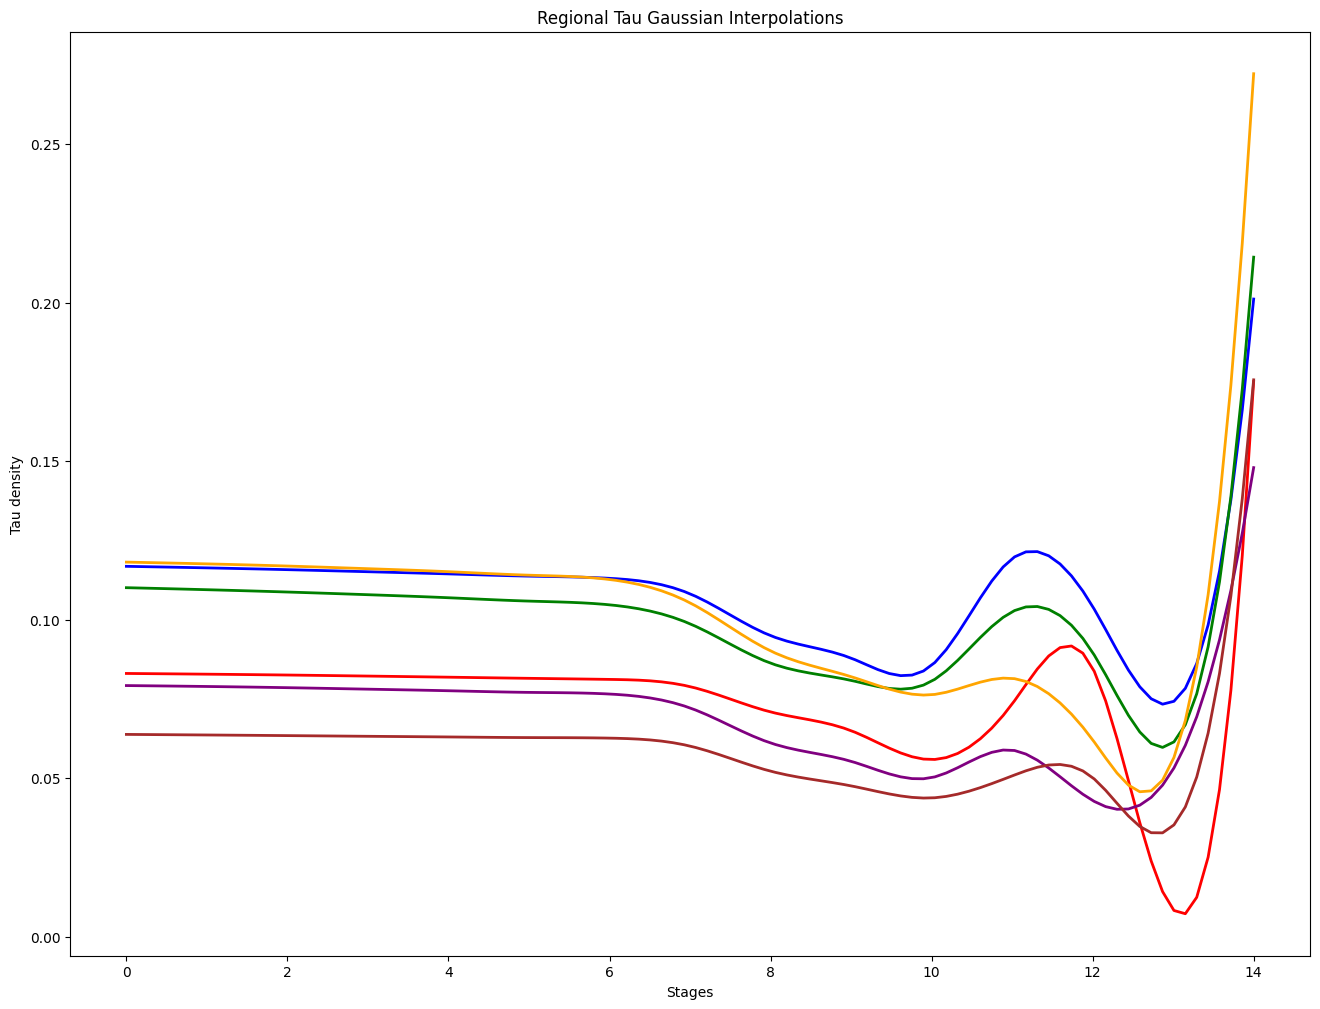

In [ ]:
# Create a data frame for the stage probability distributions for each subject from pickle file
prob_stage = pandas.DataFrame(pk['prob_stage'])
ml_stage = pandas.DataFrame(pk['ml_stage'])
prob_stage = pandas.concat([ml_stage, prob_stage], axis=1)

# Delete subjects in stages to exclude
prob_stage = prob_stage[~prob_stage.iloc[:, 0].isin(stages_to_remove)]
prob_stage.drop(prob_stage.columns[0], axis=1, inplace=True)

# Define the number of stages 
stage_count = prob_stage.shape[1]

# Define biomarkers of interest
biomarkers_of_interest = [
    'Right-Amygdala', 'Right-Hippocampus', 'ctx-rh-entorhinal', 'ctx-rh-inferiorparietal', 'ctx-rh-inferiortemporal', 'ctx-rh-parahippocampal']

# Set up the plot
plt.figure(figsize=(16, 12))
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']  # Define different colors for each biomarker

for biomarker, color in zip(biomarkers_of_interest, colors): 
    # Define biomarker data as an array dimensions 1 x i where i is the number of subjects
    biomarker_data = tau_data[biomarker]

    # Initialize lists of y(k) values and variance for each stage k
    biomarker_values = []
    variance_values = []

    for k in range(int(stage_count)):  # For each stage k
        total = 0  # Define a variable for the sum of all subjects i (numerator)

        for i in range(len(biomarker_data)):  # For each subject i 
            prob = prob_stage.iloc[i, k]  # Define the probability that subject i is in stage k 
            value = biomarker_data.iloc[i]  # Define the value of the biomarker for subject i 
            product = prob * value  # Multiply 
            total = total + product  # Add the product of the biomarker value and stage probability to the sum of i for stage k

        column_sum = np.sum(prob_stage.iloc[:, k])  # (denominator) 
        mean = total / column_sum  # Normalize with the sum of probabilities for each subject in stage k
        biomarker_values.append(mean)  # Save mean to biomarker_values list

        variance = 0  # Define variance for stage k
        
        for i in range(len(biomarker_data)):  # For each subject i 
            prob = prob_stage.iloc[i, k] 
            value = biomarker_data.iloc[i] 
            variance_individual = prob * (value - mean) ** 2
            variance = variance + variance_individual 

        variance = variance / len(biomarker_data)  # Normalize
        variance = math.sqrt(variance)  # Take the square root
        
        variance_values.append(variance)  # Save variance to list for stage k

    x = np.linspace(0, stage_count - 1, stage_count) 
    y = biomarker_values 
    variance = variance_values

    # Perform interpolation 
    f = interp1d(x, y, kind='cubic')

    # New x values for which we want to interpolate
    xnew = np.linspace(0, stage_count - 1, 100) 

    # Interpolate y values for the new x values
    ynew = f(xnew)

    # Create a shaded area for the error
    #upper = y + np.sqrt(variance)
    #lower = y - np.sqrt(variance)

    # Plotting
    #plt.fill_between(x, lower, upper, color=color, alpha=0.2)
    plt.plot(xnew, ynew, '-', color=color, label=biomarker, linewidth=2)

# Add legend, labels, and title
#plt.legend()
plt.xlabel('Stages')
plt.ylabel('Tau density')
plt.title('Regional Tau Gaussian Interpolations')
#plt.ylim(bottom=0, top=5)

In [ ]:
# Alternate probability heatmap for cognitive score order with overlay 

# Add diagnosis, cognitive score, and ml_stage to data frame
prob_stage_plot = pandas.merge(zdata,prob_stage,left_index=True, right_index=True)
prob_stage_plot = prob_stage_plot.iloc[:,[1, 3, 22] + list(range(24, prob_stage_plot.shape[1]))]

# Define your custom colormap
colors = [
    "#f4cca1",  # beige
    "#ff8c69",  # light salmon (intermediate color for smoother transition)
    "#ff5533",  # tomato red (stronger red)
    "#ff2200",  # orange red (more intense)
    "#760909"   # red (most intense)
]
custom_red_colormap = LinearSegmentedColormap.from_list("custom_red", colors)

# By cognitive score
by_cog = prob_stage_plot.sort_values(by='ADAS11')
# Normalize ADAS11_bl scores to the range of indices used in the x-axis of the heatmap
normalized_ADAS11 = (by_cog['ADAS11'] - by_cog['ADAS11'].min()) / (by_cog['ADAS11'].max() - by_cog['ADAS11'].min())
scaled_ADAS11_x = normalized_ADAS11 * (by_cog.shape[1] - 3.5)  # Scale to width of heatmap
by_cog = by_cog.iloc[:,3:]
plt.figure(figsize=(8,10))
plt.imshow(by_cog, cmap=custom_red_colormap, interpolation='none', aspect='auto')
# Generate y-values for the line plot (assuming a simple sequential order, you may adjust as needed)
y_values = np.arange(by_cog.shape[0])
# Overlay the line representing the ADAS11 score for each subject
plt.plot(scaled_ADAS11_x, y_values, color='black', marker='o', linestyle='-', linewidth=2, markersize=1, label='ADAS11 Score Line')
ax = plt.gca()  # Get the current axes
ax.set_xticklabels([])  # Remove x-axis tick labels but keep the tick marks
ax.set_yticklabels([])  # Remove y-axis tick labels but keep the tick marks

# Create a secondary x-axis
ax2 = plt.twiny()
# Define new x-ticks for the secondary x-axis. Ensure they align with primary axis
new_tick_positions = [-2, 1, 4, 7, 10, 13]  # Specify positions where you want ticks

# Set the ticks and labels for the secondary x-axis
ax2.set_xlim(ax1.get_xlim())  # Ensure alignment with primary x-axis
ax2.set_xticks(new_tick_positions)  # Set the ticks at desired positions

# Provide labels for these tick positions
#ax2.set_xticklabels(['-2', '0', '2', '4', '6', '8'])  # Corresponding labels for each tick
ax2.set_xticklabels([])

# Add a label to the secondary x-axis
#ax2.set_xlabel('ADAS11')

# Customize the plot
#plt.xlabel('Stage')
plt.ylabel('Subjects')
#plt.title('Heatmap with ADAS11 Score Overlay')
#plt.legend()
plt.show()

KeyError: 'ADAS11'

# Calculate a continous time series for a biomarker in every brain region
Perform the above operations for every brain region (currently looking at tau)

In [12]:
# Now let's calculate an interpolation for tau in every region 

column_labels = ['ctx-rh-bankssts', 'ctx-rh-caudalanteriorcingulate','ctx-rh-caudalmiddlefrontal','ctx-rh-cuneus','ctx-rh-entorhinal','ctx-rh-fusiform','ctx-rh-inferiorparietal','ctx-rh-inferiortemporal','ctx-rh-isthmuscingulate','ctx-rh-lateraloccipital','ctx-rh-lateralorbitofrontal','ctx-rh-lingual','ctx-rh-medialorbitofrontal','ctx-rh-middletemporal','ctx-rh-parahippocampal','ctx-rh-paracentral','ctx-rh-parsopercularis','ctx-rh-parsorbitalis','ctx-rh-parstriangularis','ctx-rh-pericalcarine','ctx-rh-postcentral','ctx-rh-posteriorcingulate','ctx-rh-precentral','ctx-rh-precuneus','ctx-rh-rostralanteriorcingulate','ctx-rh-rostralmiddlefrontal','ctx-rh-superiorfrontal','ctx-rh-superiorparietal','ctx-rh-superiortemporal','ctx-rh-supramarginal','ctx-rh-frontalpole','ctx-rh-temporalpole','ctx-rh-transversetemporal','ctx-rh-insula','ctx-lh-bankssts','ctx-lh-caudalanteriorcingulate','ctx-lh-caudalmiddlefrontal','ctx-lh-cuneus','ctx-lh-entorhinal','ctx-lh-fusiform','ctx-lh-inferiorparietal','ctx-lh-inferiortemporal','ctx-lh-isthmuscingulate','ctx-lh-lateraloccipital','ctx-lh-lateralorbitofrontal','ctx-lh-lingual','ctx-lh-medialorbitofrontal','ctx-lh-middletemporal','ctx-lh-parahippocampal','ctx-lh-paracentral','ctx-lh-parsopercularis','ctx-lh-parsorbitalis','ctx-lh-parstriangularis','ctx-lh-pericalcarine','ctx-lh-postcentral','ctx-lh-posteriorcingulate','ctx-lh-precentral','ctx-lh-precuneus','ctx-lh-rostralanteriorcingulate','ctx-lh-rostralmiddlefrontal','ctx-lh-superiorfrontal','ctx-lh-superiorparietal','ctx-lh-superiortemporal','ctx-lh-supramarginal','ctx-lh-frontalpole','ctx-lh-temporalpole','ctx-lh-transversetemporal','ctx-lh-insula','Left-Cerebellum-Cortex','Left-Thalamus-Proper','Left-Caudate','Left-Putamen','Left-Pallidum','Left-Hippocampus','Left-Amygdala','Left-Accumbens-area','Left-VentralDC','Right-Cerebellum-Cortex','Right-Thalamus-Proper','Right-Caudate','Right-Putamen','Right-Pallidum','Right-Hippocampus','Right-Amygdala','Right-Accumbens-area','Right-VentralDC']

if nsubtypes > 1:

    tau_array_dicts = {}
    tau_df_dicts = {}

    for subtype in range(1,nsubtypes + 1):

        tau_array_dicts[subtype] = None
         
        for region in tau_array_dicts[subtype].columns[6:]: # Loop through tau in every region 

            # Define biomarker of interest as an array dimensions 1 x i where i is the number of subjects
            biomarker_of_interest = region  
            
            # Extract the biomarker data for the current subtype
            biomarker_data = tau_array_dicts[subtype][biomarker_of_interest]

            #Initialize list of y(k) values for each stage k within biomarkers_values dictionary 
            biomarker_values_dicts[subtype] = []

            for k in range(int(stage_count)): # For each stage k
                sum = 0 # Define a variable for sum of all subjects i (numerator)

                for i in range(len(biomarker_data)): # For each subject i 
        
                    prob = prob_stage_dicts[subtype].iloc[i, k] # Define the probability that subject i is in stage k
                    value = biomarker_data.iloc[i] # Define the value of the biomarker for subject i 
                    product = prob * value # Multiply 
                    sum = sum + product # Add the product of the biomarker value and stage probability to the sum of i for stage k

                column_sum = np.sum(prob_stage.iloc[:, k]) # (denominator) 

                final_value = sum / column_sum # Normalize with sum of probabilities for each subject in stage k
    
                biomarker_values_dicts[subtype].append(final_value) # Save sum to biomarker_values list

            x = np.linspace(0, stage_count - 1,stage_count) 
            y = biomarker_values_dicts[subtype]

            # Perform interpolation 
            f = interp1d(x, y, kind='cubic')

            # New x values for which we want to interpolate
            xnew = np.linspace(0,stage_count - 1,100) 

            # Interpolate y values for the new x values
            ynew = f(xnew)

            if tau_array_dicts[subtype] is None:
                tau_array_dicts[subtype] = ynew[np.newaxis, :]  # Make ynew 2D for vertical stacking
            else:
                tau_array_dicts[subtype] = np.vstack((tau_array_dicts[subtype], ynew))
        
        print('Subtype ' + str(subtype) + ' regional tau: ' + str(tau_array_dicts[subtype]))

        # Convert tau array to labeled data frame and save to csv
        transpose_array = tau_array_dicts[subtype].T

        tau_df_dicts[subtype] = pandas.DataFrame(data=transpose_array, columns = column_labels)

else: 

    # Define an array for tau interpolations in every brain region
    tau_array = None
    
    for region in tau_data.columns[1:]: # Loop through tau in every region 
    
        # Define biomarker of interest as an array dimensions 1 x i where i is the number of subjects
        biomarker_of_interest = region  
        biomarker_data = tau_data[biomarker_of_interest] 

        # Initialize list of y(k) values for each stage k
        biomarker_values = []
    
        for k in range(int(stage_count)): # For each stage k
            sum = 0 # Define a variable for sum of all subjects i (numerator)
    
            for i in range(len(zdata)): # For each subject i 
        
                prob = prob_stage.iloc[i, k] # Define the probability that subject i is in stage k 
                value = biomarker_data.iloc[i] # Define the value of the biomarker for subject i 
                product = prob * value # Multiply 
                sum = sum + product # Add the product of the biomarker value and stage probability to the sum of i for stage k

            column_sum = np.sum(prob_stage.iloc[:, k]) # (denominator) 

            final_value = sum / column_sum # Normalize with sum of probabilities for each subject in stage k
    
            biomarker_values.append(final_value) # Save sum to biomarker_values list

    
        # Perform Gaussian interpolation with scipy.interpolate.interp1d

        x = np.linspace(0, stage_count - 1,stage_count) 
        y = biomarker_values

        # Perform interpolation 
        f = interp1d(x, y, kind='cubic')

        # New x values for which we want to interpolate
        xnew = np.linspace(0,stage_count - 1,100) 

        # Interpolate y values for the new x values
        ynew = f(xnew)

        if tau_array is None:
            tau_array = ynew[np.newaxis, :]  # Make ynew 2D for vertical stacking
        else:
            tau_array = np.vstack((tau_array, ynew))
        
    print('Regional tau: ' + str(tau_array))

    # Convert tau array to labeled data frame 
    transpose_array = tau_array.T

    column_labels = ['ctx-rh-bankssts', 'ctx-rh-caudalanteriorcingulate','ctx-rh-caudalmiddlefrontal','ctx-rh-cuneus','ctx-rh-entorhinal','ctx-rh-fusiform','ctx-rh-inferiorparietal','ctx-rh-inferiortemporal','ctx-rh-isthmuscingulate','ctx-rh-lateraloccipital','ctx-rh-lateralorbitofrontal','ctx-rh-lingual','ctx-rh-medialorbitofrontal','ctx-rh-middletemporal','ctx-rh-parahippocampal','ctx-rh-paracentral','ctx-rh-parsopercularis','ctx-rh-parsorbitalis','ctx-rh-parstriangularis','ctx-rh-pericalcarine','ctx-rh-postcentral','ctx-rh-posteriorcingulate','ctx-rh-precentral','ctx-rh-precuneus','ctx-rh-rostralanteriorcingulate','ctx-rh-rostralmiddlefrontal','ctx-rh-superiorfrontal','ctx-rh-superiorparietal','ctx-rh-superiortemporal','ctx-rh-supramarginal','ctx-rh-frontalpole','ctx-rh-temporalpole','ctx-rh-transversetemporal','ctx-rh-insula','ctx-lh-bankssts','ctx-lh-caudalanteriorcingulate','ctx-lh-caudalmiddlefrontal','ctx-lh-cuneus','ctx-lh-entorhinal','ctx-lh-fusiform','ctx-lh-inferiorparietal','ctx-lh-inferiortemporal','ctx-lh-isthmuscingulate','ctx-lh-lateraloccipital','ctx-lh-lateralorbitofrontal','ctx-lh-lingual','ctx-lh-medialorbitofrontal','ctx-lh-middletemporal','ctx-lh-parahippocampal','ctx-lh-paracentral','ctx-lh-parsopercularis','ctx-lh-parsorbitalis','ctx-lh-parstriangularis','ctx-lh-pericalcarine','ctx-lh-postcentral','ctx-lh-posteriorcingulate','ctx-lh-precentral','ctx-lh-precuneus','ctx-lh-rostralanteriorcingulate','ctx-lh-rostralmiddlefrontal','ctx-lh-superiorfrontal','ctx-lh-superiorparietal','ctx-lh-superiortemporal','ctx-lh-supramarginal','ctx-lh-frontalpole','ctx-lh-temporalpole','ctx-lh-transversetemporal','ctx-lh-insula','Left-Cerebellum-Cortex','Left-Thalamus-Proper','Left-Caudate','Left-Putamen','Left-Pallidum','Left-Hippocampus','Left-Amygdala','Left-Accumbens-area','Left-VentralDC','Right-Cerebellum-Cortex','Right-Thalamus-Proper','Right-Caudate','Right-Putamen','Right-Pallidum','Right-Hippocampus','Right-Amygdala','Right-Accumbens-area','Right-VentralDC']

    tau_df = pandas.DataFrame(data=transpose_array, columns = column_labels)
        

NameError: name 'nsubtypes' is not defined

In [ ]:
# Exclude striatal regions

# List of striatal regions to exclude from further analysis CAN EDIT THIS
regions_to_exclude = ['Left-Pallidum','Right-Pallidum','Left-Accumbens-area','Right-Accumbens-area','Right-Putamen','Left-Putamen','Right-Caudate','Left-Caudate']

# Delete striatal regions in tau_df
tau_df_excluded = tau_df.drop(columns=regions_to_exclude)
tau_array_excluded = tau_df_excluded.to_numpy()
tau_array_excluded = tau_array_excluded.T


In [ ]:
# Save data frame to csv

if nsubtypes > 1:

    for subtype in range(1,nsubtypes + 1):
    
        tau_df_dicts[subtype].to_csv(f'EBM output - subtyping.csv') # EDIT CSV NAME HERE


else:
    tau_df.to_csv('/Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/Nexis/EBM time series/EBM time series - version 9 final run.csv') # EDIT CSV NAME HERE



In [ ]:
# Preparing data frame for NexIS on individual subjects

stage_data = zdata[['RID', 'Diagnosis', 'ml_stage', 'ml_subtype']]

final = pandas.merge(stage_data, tau_data, on='RID', how='inner')

final.to_csv('/Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/Nexis/EBM stage + tau/Stage + tau - 2 subtypes.csv')
